First Attempt at GAN
1 - Load Images into Colab

In [1]:
from __future__ import print_function, division
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import tensorflow as tf
import io
from PIL import Image
import time
from IPython.display import Image as DImage
from IPython import display
print('Tensorflow version: '+ tf.__version__)

Using TensorFlow backend.


Tensorflow version: 2.1.0


In [2]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    #img = tf.io.read_file(path_to_img)
    #img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(path_to_img, tf.float32)
    img = img[tf.newaxis, :]
    print('Image loaded')
    return img
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


In [4]:
upload = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_Bridge.png")
upload2 = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_Cave.png")
upload3 = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_Forest.png")
upload4 = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_Ice.JPG")
upload5 = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_MainPage.png")
upload6 = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_Swamp.png")
upload7 = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Training Images 2\BG_Volcano.png")
test = Image.open(r"C:\Users\gabri\OneDrive\Área de Trabalho\Tibbi (2)\Iceland (1).png")

In [46]:
def convert(upload):
    uploaded_arr = tf.keras.preprocessing.image.img_to_array(
        upload, dtype='float32'
    )
    uploaded_arr = uploaded_arr/255.0
    uploaded = tf.convert_to_tensor(uploaded_arr)
    return uploaded[:,:,0:3]
upload_list = []
upload_list.append(convert(upload))
upload_list.append(convert(upload2))
upload_list.append(convert(upload3))
upload_list.append(convert(upload4))
upload_list.append(convert(upload5))
upload_list.append(convert(upload6))
upload_list.append(convert(upload7))
np_img_list = []
for img in upload_list:
    npimg = img.numpy()
    if npimg.shape[1] == 1536:
        np_img_list.append(npimg[:,:1520,:])
    else:
        np_img_list.append(npimg[:])
test_image = convert(test)

In [7]:
for img in np_img_list:
    print(img.shape)

(2048, 1520, 3)
(2048, 1520, 3)
(2048, 1520, 3)
(2048, 1520, 3)
(1536, 1200, 3)
(2048, 1520, 3)
(2048, 1520, 3)


In [8]:
# content_image = load_img(uploaded)
# test_image = load_img(test)
# #Plotting uploaded image
# plt.subplot(1, 2, 1)
# imshow(test_image, 'Content Image')

In [9]:
# type(content_image)

In [10]:
# newimg = content_image.numpy()
# i_transformed = np.copy(newimg)
# size_x = i_transformed.shape[1]
# size_y = i_transformed.shape[2]
# newimg.shape

In [11]:
def convertToTensor(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [12]:
def pool(image):
    size_x = image.shape[0]
    size_y = image.shape[1]
    new_x = int(size_x/2)
    new_y = int(size_y/2)
    newImage = np.zeros((new_x, new_y,3))
    for z in range(3):
        for x in range(0, size_x, 2):
            for y in range(0, size_y, 2):
                pixels = []
                pixels.append(image[x, y,z])
                pixels.append(image[x+1, y,z])
                pixels.append(image[x, y+1,z])
                pixels.append(image[x+1, y+1,z])
                pixels.sort(reverse=True)
                newImage[int(x/2),int(y/2),z] = pixels[0]
            
    return newImage

In [13]:
def flip(arg):
    newImages = []
    #returns 4 flipped tensors, one being the original
    flipped_hor = tf.image.flip_left_right(arg)
    flipped_vert = tf.image.flip_up_down(arg)
    flipped_twice = tf.image.flip_up_down(flipped_hor)
    newImages.append(arg)
    newImages.append(flipped_hor)
    newImages.append(flipped_vert)
    newImages.append(flipped_twice)
    res = tf.stack(newImages)
    return res

In [14]:
def crop(i_transformed):
    #Cropping the picture
    SIZE = 128 #Size we want the final img to be shape =  (SIZE,SIZE,3)
    size_x = i_transformed.shape[1]
    size_y = i_transformed.shape[0]
    img_list = []
    stepx = 40
    stepy = 32
    for x in range(0,size_x - SIZE, stepx):
        for y in range(0, size_y - SIZE, stepy):
            cropped_img = i_transformed[y:y+SIZE , x:x+SIZE,:] #returns a (128,128,3) array
            e_img = convertToTensor(cropped_img)
            img_list.append(e_img)
    res = tf.stack(img_list)
    return res

In [13]:
full_list =[]
for img in np_img_list:
    pooledImg = pool(img)
    cropped_images = crop(pooledImg)
    for img in cropped_images:
        full_list.append(flip(img))

In [14]:
final_list = tf.concat(full_list,0)

In [15]:
print("Amount of trainning samples: "+ str(final_list.shape[0]) + " with shape: "+ str(final_list.shape))

Amount of trainning samples: 11712 with shape: (11712, 128, 128, 3)


In [16]:
BUFFER_SIZE = 1000
BATCH_SIZE = 20

In [17]:
train_images = final_list
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
train_images.shape

TensorShape([11712, 128, 128, 3])

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(3*64*64, use_bias=False, input_shape=(12288,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 48)))
    assert model.output_shape == (None, 16, 16, 48) # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(48, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 48)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [16]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12288)             150994944 
_________________________________________________________________
batch_normalization (BatchNo (None, 12288)             49152     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12288)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 48)        57600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 48)        192       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 48)        0

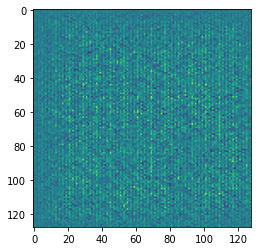

In [17]:
noise = tf.random.normal([1, 12288])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [18]:
#keras.utils.plot_model(generator, "generator.png", show_shapes=True)

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(3))
    
    return model

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[ 0.00010352 -0.00165702 -0.00097659]], shape=(1, 3), dtype=float32)


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #original 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #original 1e-4

In [25]:
EPOCHS = 40
noise_dim = 12288
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# generator.compile(loss= 'mse', optimizer='Adam' ,metrics =['accuracy','mse'])
# discriminator.compile(loss= 'mse', optimizer='Adam' ,metrics =['accuracy','mse'])

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [27]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [28]:
def train(dataset, epochs):
    loss_list = []
    for epoch in range(epochs):
        start = time.time()
        i=0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            d = dict([
                ("epoch",epoch),
                ("batch",i),
                ("gen_loss",gen_loss),
                ("disc_loss",disc_loss)
            ])
            loss_list.append(d)
        #if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec, batch: {}'.format(epoch + 1, time.time()-start, i))
            i+=1
        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epoch,
                               seed)
    return loss_list

In [29]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    #fig = plt.figure(figsize=(4,4))

#     for i in range(predictions.shape[0]):
#         #plt.subplot(4, 4, i+1)
#         Image = predictions[i, :, :, :] * 127.5 + 127.5
#         Image = Image/np.amax(Image)
    Image = np.clip(predictions[:, :, :, :], 0, 1)
        #plt.imshow(Image)
    plt.axis('off')
    imshow(Image)

    plt.savefig('image_at_epoch_{}.png'.format(epoch))
    plt.show()

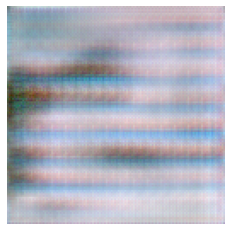

In [35]:
loss_list = train(train_dataset, EPOCHS)

In [36]:
loss_list[0].get('gen_loss').numpy()
xValues = []
genValues = []
discValues = []
for batch in loss_list:
    e = batch.get('epoch')
    b = batch.get('batch') / 100
    gl = batch.get('gen_loss').numpy()
    dl = batch.get('gen_loss').numpy()
    value = e + b
    xValues.append(value)
    genValues.append(gl)
    discValues.append(dl)

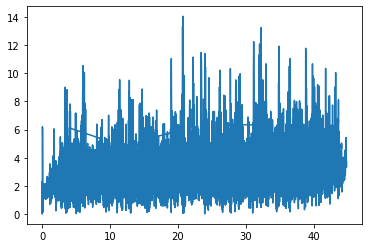

In [37]:
loss_plt = plt.plot(xValues, discValues)

In [38]:
#Saving the model
generator.save("GAN_Generator_e4_6")
discriminator.save("GAN_Discriminator_e4_6")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: GAN_Generator_e4_6\assets
INFO:tensorflow:Assets written to: GAN_Discriminator_e4_6\assets


In [30]:
generator = keras.models.load_model("GAN_Generator_e4_6")
discriminator = keras.models.load_model("GAN_Discriminator_e4_6")

In [37]:
test_Image.shape

TensorShape([2000, 3600, 3])

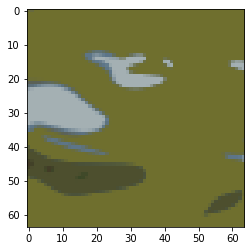

In [51]:
z = 64
x = 12
y = 12
test_Image = np.clip(test_image[x*z:(x*z)+z, y*z:(y*z)+z, 0:3], 0, 1)
imshow(test_Image)
#imshow(generated_image[:, :, :, :])

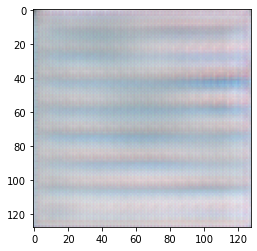

In [44]:
test_noise = tf.reshape(test_Image, [1,12288])
noise = tf.random.normal([1, 12288])
generated_image = generator(test_noise, training=False)
Image = np.clip(generated_image, 0, 1)
imshow(Image)
#imshow(generated_image[:, :, :, :])